In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.master("local[*]").appName("ElectricityDemandForecasting").getOrCreate()

# Verify Spark Session
print(spark)


In [ ]:
# Load the CSV Files into Spark

In [2]:
# Load state-wise power generation dataset
df_states = spark.read.csv("C:/Users/rakshita/electricitydemandanalysis/Daily_Power_Gen_States_march_23.csv", 
                           header=True, inferSchema=True)

# Show schema & first few rows
df_states.printSchema()
df_states.show(5)


root
 |-- Region: string (nullable = true)
 |-- States: string (nullable = true)
 |-- Max.Demand Met during the day(MW): double (nullable = true)
 |-- Shortage during maximum Demand(MW): double (nullable = true)
 |-- Energy Met (MU): string (nullable = true)
 |-- date: date (nullable = true)

+------+-----------+---------------------------------+----------------------------------+---------------+----------+
|Region|     States|Max.Demand Met during the day(MW)|Shortage during maximum Demand(MW)|Energy Met (MU)|      date|
+------+-----------+---------------------------------+----------------------------------+---------------+----------+
|   NER|    Mizoram|                             77.0|                               1.0|            1.2|2015-01-01|
|    WR|         DD|                            214.0|                               0.0|            4.8|2015-01-01|
|    WR|        Goa|                            383.0|                               0.0|            7.3|2015-01-01|
|   

In [16]:
df_states = df_states.withColumnRenamed("Region", "Region_Name") \
                     .withColumnRenamed("States", "State_Name") \
                     .withColumnRenamed("Max.Demand Met during the day(MW)", "Max_Demand_Met_MW") \
                     .withColumnRenamed("Shortage during maximum Demand(MW)", "Shortage_MW") \
                     .withColumnRenamed("Energy Met (MU)", "Energy_Met_MU")

# Verify the column names
df_states.printSchema()


root
 |-- Region_Name: string (nullable = true)
 |-- State_Name: string (nullable = true)
 |-- Max_Demand_Met_MW: double (nullable = true)
 |-- Shortage_MW: double (nullable = true)
 |-- Energy_Met_MU: string (nullable = true)
 |-- date: date (nullable = true)



In [12]:
# Load power generation by source dataset
df_sources = spark.read.csv("C:/Users/rakshita/electricitydemandanalysis/Daily_Power_Gen_Source_march_23.csv", 
                            header=True, inferSchema=True)

# Show schema & first few rows
df_sources.printSchema()
df_sources.show(5)


root
 |-- source: string (nullable = true)
 |-- NR: double (nullable = true)
 |-- WR: double (nullable = true)
 |-- SR: double (nullable = true)
 |-- ER: double (nullable = true)
 |-- NER: double (nullable = true)
 |-- All India: integer (nullable = true)
 |-- date: date (nullable = true)

+------------+-----+-----+-----+-----+----+---------+----------+
|      source|   NR|   WR|   SR|   ER| NER|All India|      date|
+------------+-----+-----+-----+-----+----+---------+----------+
|       Hydro|139.0| 43.0| 72.0| 30.0| 7.0|      292|2013-03-31|
|       Total|675.0|820.0|697.0|306.0|28.0|     2526|2013-03-31|
|Wind Gen(MU)|  2.0| 19.0| 13.0|  0.0| 0.0|       34|2013-03-31|
|       Hydro|137.0| 43.0| 83.0| 32.0| 5.0|      300|2013-04-01|
|       Total|683.0|841.0|706.0|316.0|29.0|     2575|2013-04-01|
+------------+-----+-----+-----+-----+----+---------+----------+
only showing top 5 rows



In [17]:
df_sources = df_sources.withColumnRenamed("source", "Energy_Source") \
                       .withColumnRenamed("All India", "All_India_Generation")

# Verify the column names
df_sources.printSchema()


root
 |-- Energy_Source: string (nullable = true)
 |-- NR: double (nullable = true)
 |-- WR: double (nullable = true)
 |-- SR: double (nullable = true)
 |-- ER: double (nullable = true)
 |-- NER: double (nullable = true)
 |-- All_India_Generation: integer (nullable = true)
 |-- date: date (nullable = true)



In [4]:
# Data Cleaning & Preprocessing

In [5]:
# Convert date Column to Datetime Format

In [13]:
from pyspark.sql.functions import to_date

# Convert 'date' column to Spark's Date format
df_states = df_states.withColumn("date", to_date(df_states["date"], "yyyy-MM-dd"))
df_sources = df_sources.withColumn("date", to_date(df_sources["date"], "yyyy-MM-dd"))

# Verify the changes
df_states.printSchema()
df_sources.printSchema()


root
 |-- Region: string (nullable = true)
 |-- States: string (nullable = true)
 |-- Max_Demand_Met_MW: double (nullable = true)
 |-- Shortage_MW: double (nullable = true)
 |-- Energy_Met_MU: string (nullable = true)
 |-- date: date (nullable = true)

root
 |-- source: string (nullable = true)
 |-- NR: double (nullable = true)
 |-- WR: double (nullable = true)
 |-- SR: double (nullable = true)
 |-- ER: double (nullable = true)
 |-- NER: double (nullable = true)
 |-- All India: integer (nullable = true)
 |-- date: date (nullable = true)



In [14]:
from pyspark.sql.functions import col, sum, when

# Count missing values in df_states
df_states.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_states.columns]).show()

# Count missing values in df_sources
df_sources.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_sources.columns]).show()


+------+------+-----------------+-----------+-------------+----+
|Region|States|Max_Demand_Met_MW|Shortage_MW|Energy_Met_MU|date|
+------+------+-----------------+-----------+-------------+----+
|     0|     0|                1|         20|            2|   2|
+------+------+-----------------+-----------+-------------+----+

+------+---+---+---+---+---+---------+----+
|source| NR| WR| SR| ER|NER|All India|date|
+------+---+---+---+---+---+---------+----+
|     0|  0|  0|  0|  0|  0|        0|   0|
+------+---+---+---+---+---+---------+----+



In [ ]:
# Converts rows (Hydro, Wind, Solar, etc.) into separate columns.
# Each column now represents daily generation from a specific energy source.

In [18]:
df_sources_pivot = df_sources.groupBy("date").pivot("Energy_Source").sum("All_India_Generation")

# Show the transformed dataset
df_sources_pivot.show(5)


+----------+----+--------------------+-----+-------+-------+-----------------------------------+--------------+------------------------+-----+------------+
|      date|Coal|Gas, Naptha & Diesel|Hydro|Lignite|Nuclear|RES (Wind, Solar, Biomass & Others)|Solar Gen (MU)|Thermal (Coal & Lignite)|Total|Wind Gen(MU)|
+----------+----+--------------------+-----+-------+-------+-----------------------------------+--------------+------------------------+-----+------------+
|2014-09-26|NULL|                NULL|  546|   NULL|   NULL|                               NULL|          NULL|                    NULL| 3069|          27|
|2022-07-31|2605|                  58|  724|     94|    108|                                539|          NULL|                    NULL| 4128|        NULL|
|2019-06-04|2829|                 141|  502|     70|     92|                                471|          NULL|                    NULL| 4104|        NULL|
|2020-08-24|2113|                 121|  729|     58|    115|    

In [20]:
# Merge Both Datasets

In [21]:
df_merged = df_states.join(df_sources_pivot, on="date", how="left")

# Show the merged dataset
df_merged.show(5)


+----------+-----------+-----------+-----------------+-----------+-------------+----+--------------------+-----+-------+-------+-----------------------------------+--------------+------------------------+-----+------------+
|      date|Region_Name| State_Name|Max_Demand_Met_MW|Shortage_MW|Energy_Met_MU|Coal|Gas, Naptha & Diesel|Hydro|Lignite|Nuclear|RES (Wind, Solar, Biomass & Others)|Solar Gen (MU)|Thermal (Coal & Lignite)|Total|Wind Gen(MU)|
+----------+-----------+-----------+-----------------+-----------+-------------+----+--------------------+-----+-------+-------+-----------------------------------+--------------+------------------------+-----+------------+
|2015-01-01|        NER|    Mizoram|             77.0|        1.0|          1.2|NULL|                NULL|  185|   NULL|   NULL|                               NULL|          NULL|                    NULL| 2662|          71|
|2015-01-01|         WR|         DD|            214.0|        0.0|          4.8|NULL|                NUL

In [ ]:
# Expanding Data to Hourly Granularity

In [22]:
from pyspark.sql.functions import explode, sequence, lit

# Create a new column with 24 hourly timestamps for each date
df_expanded = df_merged.withColumn("hour", explode(sequence(lit(0), lit(23), lit(1))))

# Show the expanded dataset
df_expanded.show(5)


+----------+-----------+----------+-----------------+-----------+-------------+----+--------------------+-----+-------+-------+-----------------------------------+--------------+------------------------+-----+------------+----+
|      date|Region_Name|State_Name|Max_Demand_Met_MW|Shortage_MW|Energy_Met_MU|Coal|Gas, Naptha & Diesel|Hydro|Lignite|Nuclear|RES (Wind, Solar, Biomass & Others)|Solar Gen (MU)|Thermal (Coal & Lignite)|Total|Wind Gen(MU)|hour|
+----------+-----------+----------+-----------------+-----------+-------------+----+--------------------+-----+-------+-------+-----------------------------------+--------------+------------------------+-----+------------+----+
|2015-01-01|        NER|   Mizoram|             77.0|        1.0|          1.2|NULL|                NULL|  185|   NULL|   NULL|                               NULL|          NULL|                    NULL| 2662|          71|   0|
|2015-01-01|        NER|   Mizoram|             77.0|        1.0|          1.2|NULL|    

In [32]:
# column renaming

In [66]:
df_expanded = df_expanded.withColumnRenamed("Gas, Naptha & Diesel", "Gas_Naptha_Diesel") \
                     .withColumnRenamed("RES (Wind, Solar, Biomass & Others)", "Renewable_Energy") \
                     .withColumnRenamed("Solar Gen (MU)", "Solar_Gen_MU") \
                     .withColumnRenamed("Thermal (Coal & Lignite)", "Thermal_Coal_Lignite") \
                     .withColumnRenamed("Wind Gen(MU)", "Wind_Gen_MU")


In [67]:
print(df_expanded.columns)

['date', 'Region_Name', 'State_Name', 'Max_Demand_Met_MW', 'Shortage_MW', 'Energy_Met_MU', 'Coal', 'Gas_Naptha_Diesel', 'Hydro', 'Lignite', 'Nuclear', 'Renewable_Energy', 'Solar_Gen_MU', 'Thermal_Coal_Lignite', 'Total', 'Wind_Gen_MU', 'hour']


In [42]:
# Querying for Key Insights

In [68]:
df_expanded.printSchema()
df_expanded.show(5)


root
 |-- date: date (nullable = true)
 |-- Region_Name: string (nullable = true)
 |-- State_Name: string (nullable = true)
 |-- Max_Demand_Met_MW: double (nullable = true)
 |-- Shortage_MW: double (nullable = true)
 |-- Energy_Met_MU: string (nullable = true)
 |-- Coal: long (nullable = true)
 |-- Gas_Naptha_Diesel: long (nullable = true)
 |-- Hydro: long (nullable = true)
 |-- Lignite: long (nullable = true)
 |-- Nuclear: long (nullable = true)
 |-- Renewable_Energy: long (nullable = true)
 |-- Solar_Gen_MU: long (nullable = true)
 |-- Thermal_Coal_Lignite: long (nullable = true)
 |-- Total: long (nullable = true)
 |-- Wind_Gen_MU: long (nullable = true)
 |-- hour: integer (nullable = false)

+----------+-----------+----------+-----------------+-----------+-------------+----+-----------------+-----+-------+-------+----------------+------------+--------------------+-----+-----------+----+
|      date|Region_Name|State_Name|Max_Demand_Met_MW|Shortage_MW|Energy_Met_MU|Coal|Gas_Naptha_Di

In [26]:
#Register DataFrame as a Temporary SQL Table

In [69]:
df_expanded.createOrReplaceTempView("electricity_data")


In [ ]:
# QUERIES

In [46]:
# Total Energy Met Per Year

In [57]:
spark.sql("""
    SELECT YEAR(date) AS Year, 
           SUM(Energy_Met_MU) AS Total_Energy_Met
    FROM electricity_data
    WHERE YEAR(date) IS NOT NULL  -- ✅ Removes NULL Year entries
    GROUP BY Year
    ORDER BY Year
""").show()


+----+------------------+
|Year|  Total_Energy_Met|
+----+------------------+
|2013| 700557.9000000003|
|2014|1023176.0999999928|
|2015|1057360.6999999979|
|2016|1133094.0999999996|
|2017|1166541.4000000039|
|2018|1246999.9999999995|
|2019|1279042.2999999963|
|2020|1099118.6600000018|
|2021|1341233.3999999985|
|2022|1478352.6999999962|
|2023|371539.99999999965|
+----+------------------+



In [ ]:
# Maximum Demand Met Per Year

In [59]:
spark.sql("""
    SELECT YEAR(date) AS Year, 
           MAX(Max_Demand_Met_MW) AS Max_Demand
    FROM electricity_data
    WHERE YEAR(date) IS NOT NULL
    GROUP BY Year
    ORDER BY Year
""").show()


+----+----------+
|Year|Max_Demand|
+----+----------+
|2013|  111539.0|
|2014|   20662.0|
|2015|   21064.0|
|2016|   20951.0|
|2017|   23587.0|
|2018|   24962.0|
|2019|   23613.0|
|2020|   33137.0|
|2021|   25644.0|
|2022|   28914.0|
|2023|   28566.0|
+----+----------+



In [ ]:
# Energy Met Per State

In [48]:
spark.sql("""
    SELECT State_Name, SUM(Energy_Met_MU) AS Total_Energy_Met
    FROM electricity_data
    GROUP BY State_Name
    ORDER BY Total_Energy_Met DESC
""").show()


+--------------+------------------+
|    State_Name|  Total_Energy_Met|
+--------------+------------------+
|   Maharashtra|1508996.7000000025|
|       Gujarat|         1095070.0|
|            UP|1078690.9999999977|
|    Tamil Nadu|1015337.7000000001|
|     Rajasthan| 750906.9000000012|
|            MP| 697695.1999999998|
|     Karnataka| 660235.0000000006|
|Andhra Pradesh| 618809.4999999984|
|     Telangana| 537923.3000000009|
|        Punjab| 534217.6000000002|
|       Haryana| 495712.4999999999|
|   West Bengal|487573.82000000076|
|         Delhi|299180.50000000023|
|        Odisha| 293916.5999999998|
|  Chhattisgarh|287786.49999999977|
|         Bihar|265666.54999999976|
|        Kerala|237001.49999999994|
|           DVC|221430.69999999995|
|   Uttarakhand|129088.40000000018|
|            HP| 95484.40000000008|
+--------------+------------------+
only showing top 20 rows



In [ ]:
# Total Generation by Energy Source Per Year

In [53]:
spark.sql("""
    SELECT YEAR(date) AS Year, 
           SUM(Coal) AS Total_Coal,
           SUM(Gas_Naptha_Diesel) AS Total_Gas_Diesel,
           SUM(Hydro) AS Total_Hydro,
           SUM(Lignite) AS Total_Lignite,
           SUM(Nuclear) AS Total_Nuclear,
           SUM(Solar_Gen_MU) AS Total_Solar,
           SUM(Wind_Gen_MU) AS Total_Wind,
           SUM(Thermal_Coal_Lignite) AS Total_Thermal,
           SUM(Renewable_Energy) AS Total_Renewable
    FROM electricity_data
    GROUP BY Year
    ORDER BY Year
""").show()



+----+----------+----------------+-----------+-------------+-------------+-----------+----------+-------------+---------------+
|Year|Total_Coal|Total_Gas_Diesel|Total_Hydro|Total_Lignite|Total_Nuclear|Total_Solar|Total_Wind|Total_Thermal|Total_Renewable|
+----+----------+----------------+-----------+-------------+-------------+-----------+----------+-------------+---------------+
|NULL|      NULL|            NULL|       NULL|         NULL|         NULL|       NULL|      NULL|         NULL|           NULL|
|2013|      NULL|            NULL|    3896789|         NULL|         NULL|       NULL|    763672|         NULL|           NULL|
|2014|      NULL|            NULL|    4876534|         NULL|         NULL|       NULL|   1000419|         NULL|           NULL|
|2015|      NULL|            NULL|    4932310|         NULL|         NULL|       NULL|   1066415|         NULL|           NULL|
|2016|      NULL|            NULL|    4723156|         NULL|         NULL|      91448|   1432710|       

In [55]:
spark.sql("""
    SELECT YEAR(date) AS Year, 
           SUM(Coal) AS Total_Coal,
           SUM(Gas_Naptha_Diesel) AS Total_Gas_Diesel,
           SUM(Hydro) AS Total_Hydro,
           SUM(Lignite) AS Total_Lignite,
           SUM(Nuclear) AS Total_Nuclear,
           SUM(Solar_Gen_MU) AS Total_Solar,
           SUM(Wind_Gen_MU) AS Total_Wind,
           SUM(Thermal_Coal_Lignite) AS Total_Thermal,
           SUM(Renewable_Energy) AS Total_Renewable
    FROM electricity_data
    WHERE YEAR(date) IS NOT NULL  -- ✅ Removes NULL Year entries
    GROUP BY Year
    ORDER BY Year
""").show()


+----+----------+----------------+-----------+-------------+-------------+-----------+----------+-------------+---------------+
|Year|Total_Coal|Total_Gas_Diesel|Total_Hydro|Total_Lignite|Total_Nuclear|Total_Solar|Total_Wind|Total_Thermal|Total_Renewable|
+----+----------+----------------+-----------+-------------+-------------+-----------+----------+-------------+---------------+
|2013|      NULL|            NULL|    3896789|         NULL|         NULL|       NULL|    763672|         NULL|           NULL|
|2014|      NULL|            NULL|    4876534|         NULL|         NULL|       NULL|   1000419|         NULL|           NULL|
|2015|      NULL|            NULL|    4932310|         NULL|         NULL|       NULL|   1066415|         NULL|           NULL|
|2016|      NULL|            NULL|    4723156|         NULL|         NULL|      91448|   1432710|         NULL|           NULL|
|2017|      NULL|          660096|    4997913|         NULL|       453060|     312003|   1383211|     11

In [56]:
spark.sql("""
    SELECT YEAR(date) AS Year, 
           SUM(COALESCE(Coal, 0)) AS Total_Coal,
           SUM(COALESCE(Gas_Naptha_Diesel, 0)) AS Total_Gas_Diesel,
           SUM(COALESCE(Hydro, 0)) AS Total_Hydro,
           SUM(COALESCE(Lignite, 0)) AS Total_Lignite,
           SUM(COALESCE(Nuclear, 0)) AS Total_Nuclear,
           SUM(COALESCE(Solar_Gen_MU, 0)) AS Total_Solar,
           SUM(COALESCE(Wind_Gen_MU, 0)) AS Total_Wind,
           SUM(COALESCE(Thermal_Coal_Lignite, 0)) AS Total_Thermal,
           SUM(COALESCE(Renewable_Energy, 0)) AS Total_Renewable
    FROM electricity_data
    WHERE YEAR(date) IS NOT NULL  
    GROUP BY Year
    ORDER BY Year
""").show()


+----+----------+----------------+-----------+-------------+-------------+-----------+----------+-------------+---------------+
|Year|Total_Coal|Total_Gas_Diesel|Total_Hydro|Total_Lignite|Total_Nuclear|Total_Solar|Total_Wind|Total_Thermal|Total_Renewable|
+----+----------+----------------+-----------+-------------+-------------+-----------+----------+-------------+---------------+
|2013|         0|               0|    3896789|            0|            0|          0|    763672|            0|              0|
|2014|         0|               0|    4876534|            0|            0|          0|   1000419|            0|              0|
|2015|         0|               0|    4932310|            0|            0|          0|   1066415|            0|              0|
|2016|         0|               0|    4723156|            0|            0|      91448|   1432710|            0|              0|
|2017|         0|          660096|    4997913|            0|       453060|     312003|   1383211|     11

In [ ]:
# Shortage Trends Per Year

In [60]:
spark.sql("""
    SELECT YEAR(date) AS Year, SUM(Shortage_MW) AS Total_Shortage
    FROM electricity_data
    WHERE YEAR(date) IS NOT NULL
    GROUP BY Year
    ORDER BY Year
""").show()


+----+--------------+
|Year|Total_Shortage|
+----+--------------+
|2013|     1518287.0|
|2014|     2019378.0|
|2015|     1747962.0|
|2016|      558606.0|
|2017|      409729.0|
|2018|      361690.0|
|2019|      314072.0|
|2020|      165297.0|
|2021|      184196.0|
|2022|      230598.3|
|2023|       31200.0|
+----+--------------+



In [ ]:
# Peak Shortage States

In [51]:
spark.sql("""
    SELECT State_Name, SUM(Shortage_MW) AS Total_Shortage
    FROM electricity_data
    GROUP BY State_Name
    ORDER BY Total_Shortage DESC
    LIMIT 10
""").show()


+--------------------+--------------+
|          State_Name|Total_Shortage|
+--------------------+--------------+
|                  UP|     2773269.0|
|                 J&K|      930862.0|
|           Karnataka|      628063.0|
|          Tamil Nadu|      596841.3|
|      Andhra Pradesh|      411164.0|
|               Assam|      266161.0|
|         Maharashtra|      261302.0|
|               Bihar|      257918.0|
|J&K(UT) & Ladakh(UT)|      212169.0|
|           Rajasthan|      185218.0|
+--------------------+--------------+



In [ ]:
# DATA VISUALIZATION

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [79]:
electricity_data = spark.table("electricity_data")


In [78]:
# Convert electricity_data to Pandas
electricity_df = electricity_data.toPandas()


In [ ]:
# Trend of Electricity Demand Over Time

In [83]:
print(electricity_df.dtypes)

date                     object
Region_Name              object
State_Name               object
Max_Demand_Met_MW       float64
Shortage_MW             float64
Energy_Met_MU            object
Coal                    float64
Gas_Naptha_Diesel       float64
Hydro                   float64
Lignite                 float64
Nuclear                 float64
Renewable_Energy        float64
Solar_Gen_MU            float64
Thermal_Coal_Lignite    float64
Total                   float64
Wind_Gen_MU             float64
hour                      int32
dtype: object


In [ ]:
# converting Date in datetime format

In [109]:
electricity_df["date"] = pd.to_datetime(electricity_df["date"], errors="coerce")
print(electricity_df.dtypes) 


date                     datetime64[ns]
Region_Name                      object
State_Name                       object
Max_Demand_Met_MW               float64
Shortage_MW                     float64
Energy_Met_MU                   float64
Coal                            float64
Gas_Naptha_Diesel               float64
Hydro                           float64
Lignite                         float64
Nuclear                         float64
Renewable_Energy                float64
Solar_Gen_MU                    float64
Thermal_Coal_Lignite            float64
Total                           float64
Wind_Gen_MU                     float64
hour                              int32
Log_Max_Demand_Met_MW           float64
Year                            float64
dtype: object


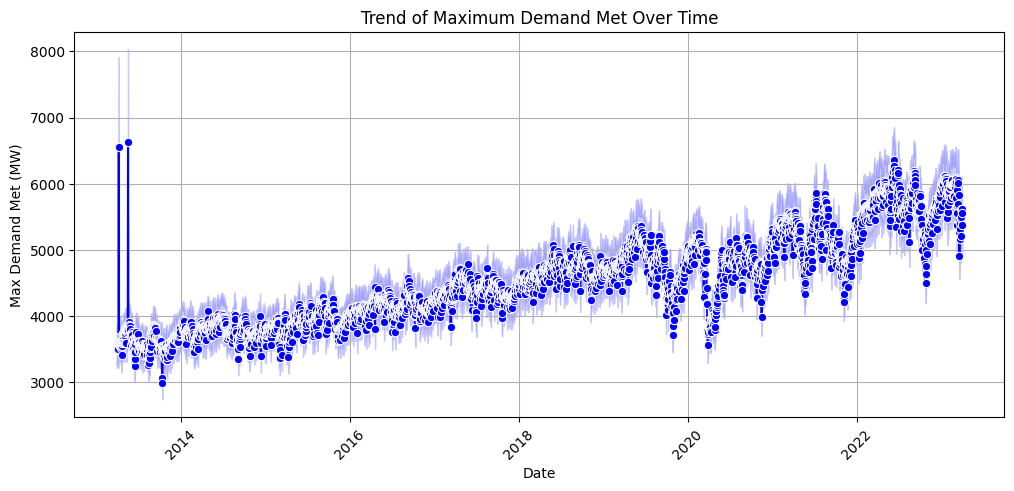

In [87]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=electricity_df, x="date", y="Max_Demand_Met_MW", marker="o", color="b")
plt.xticks(rotation=45)
plt.title("Trend of Maximum Demand Met Over Time")
plt.xlabel("Date")
plt.ylabel("Max Demand Met (MW)")
plt.grid()
plt.show()


In [ ]:
#  Shortage During Maximum Demand Over Time

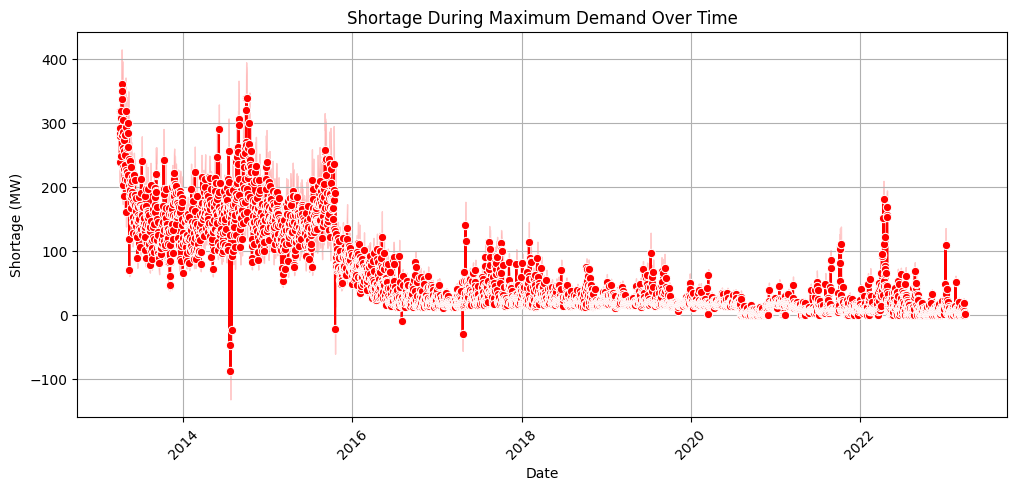

In [99]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=electricity_df, x="date", y="Shortage_MW", marker="o", color="r")
plt.xticks(rotation=45)
plt.title("Shortage During Maximum Demand Over Time")
plt.xlabel("Date")
plt.ylabel("Shortage (MW)")
plt.grid()
plt.show()



In [ ]:
# Energy Generation by Source (Stacked Area Plot)

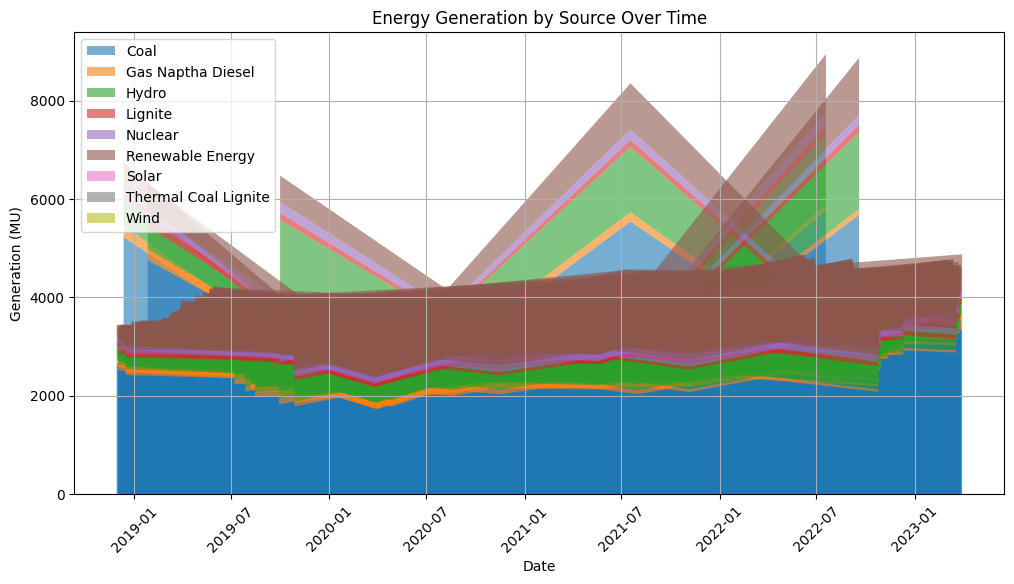

In [100]:
plt.figure(figsize=(12, 6))
plt.stackplot(electricity_df["date"], 
              electricity_df["Coal"], electricity_df["Gas_Naptha_Diesel"], electricity_df["Hydro"], 
              electricity_df["Lignite"], electricity_df["Nuclear"], electricity_df["Renewable_Energy"], 
              electricity_df["Solar_Gen_MU"], electricity_df["Thermal_Coal_Lignite"], 
              electricity_df["Wind_Gen_MU"],
              labels=["Coal", "Gas Naptha Diesel", "Hydro", "Lignite", "Nuclear", 
                      "Renewable Energy", "Solar", "Thermal Coal Lignite", "Wind"],
              alpha=0.6)
plt.xticks(rotation=45)
plt.legend(loc="upper left")
plt.title("Energy Generation by Source Over Time")
plt.xlabel("Date")
plt.ylabel("Generation (MU)")
plt.grid()
plt.show()


In [105]:
# Distribution of Maximum Demand Met

In [106]:
import numpy as np

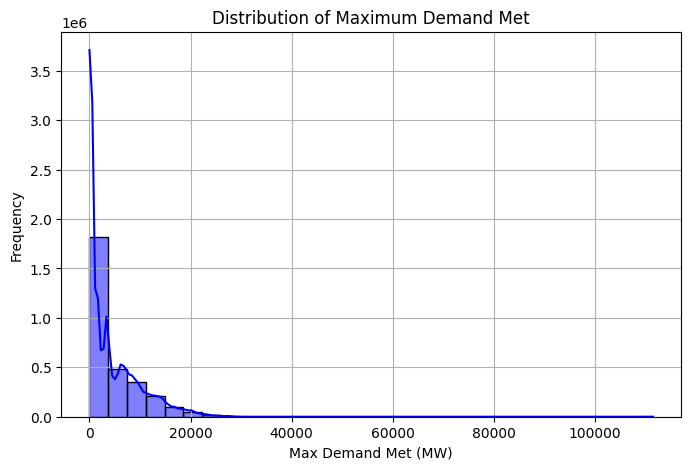

In [101]:
plt.figure(figsize=(8, 5))
sns.histplot(electricity_df["Max_Demand_Met_MW"], bins=30, kde=True, color="b")
plt.title("Distribution of Maximum Demand Met")
plt.xlabel("Max Demand Met (MW)")
plt.ylabel("Frequency")
plt.grid()
plt.show()


In [ ]:
# Correlation Heatmap of Energy Variables

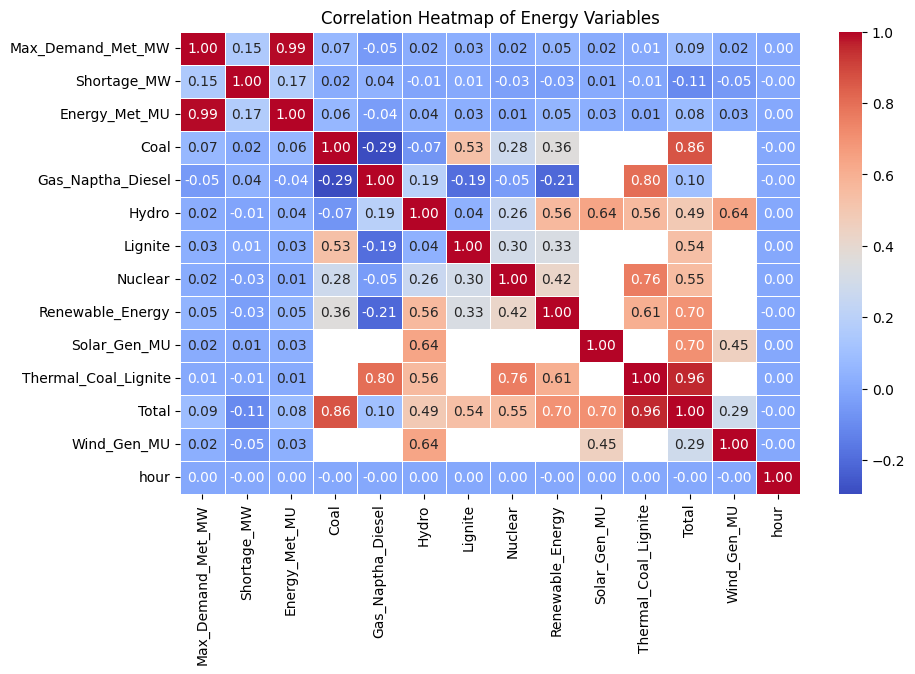

In [102]:
plt.figure(figsize=(10, 6))
sns.heatmap(electricity_df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Energy Variables")
plt.show()


In [ ]:
# Total Power Generation per State (2013-2023)

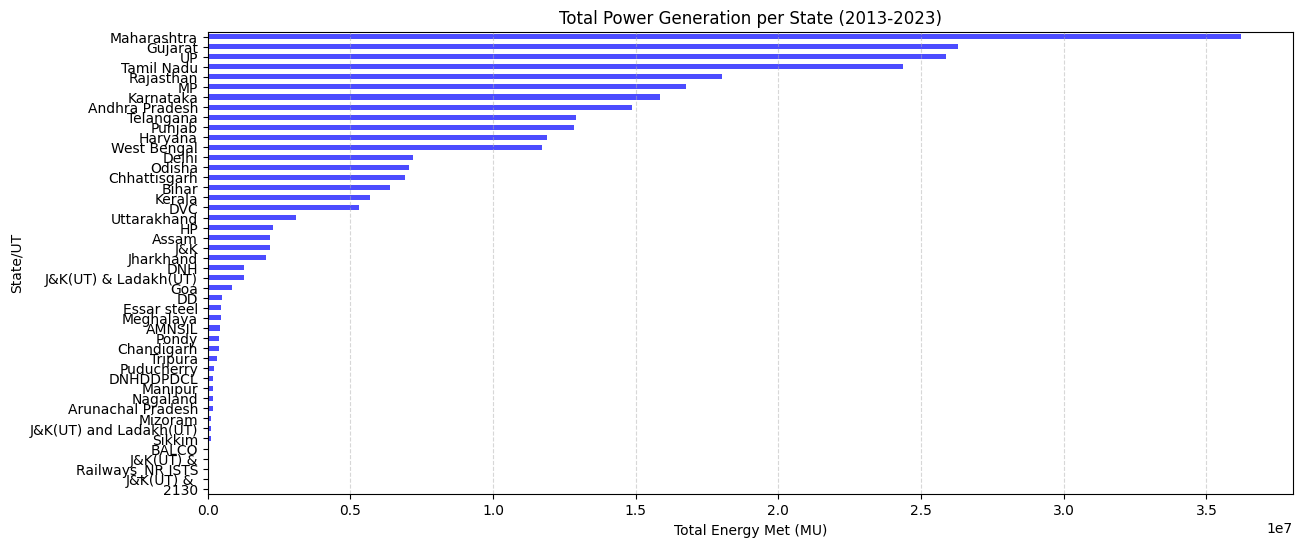

In [114]:
plt.figure(figsize=(14, 6))
state_totals = electricity_df.groupby("State_Name")["Energy_Met_MU"].sum().sort_values()
state_totals.plot(kind="barh", color="blue", alpha=0.7)

plt.xlabel("Total Energy Met (MU)")
plt.ylabel("State/UT")
plt.title("Total Power Generation per State (2013-2023)")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()


In [ ]:
# Monthly Trends in Power Generation by State

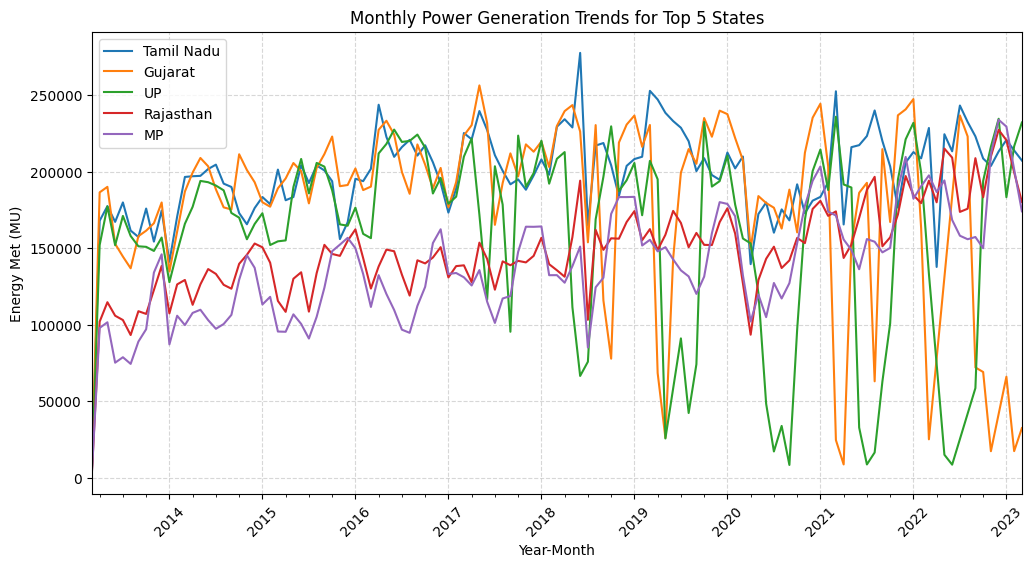

In [141]:
plt.figure(figsize=(12, 6))
electricity_df["Year-Month"] = electricity_df["date"].dt.to_period("M")

# Select top 5 states with highest total generation
top_states = electricity_df.groupby("State_Name")["Energy_Met_MU"].sum().nlargest(5).index
for state in top_states:
    state_data = electricity_df[electricity_df["State_Name"] == state].groupby("Year-Month")["Energy_Met_MU"].sum()
    state_data.plot(label=state)

plt.xlabel("Year-Month")
plt.ylabel("Energy Met (MU)")
plt.title("Monthly Power Generation Trends for Top 5 States")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [ ]:
#  State-wise Contribution to Total Power Generation

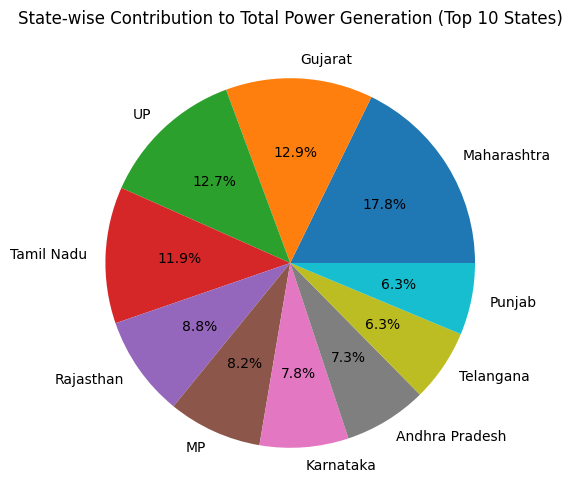

In [118]:
plt.figure(figsize=(10, 6))
state_totals.nlargest(10).plot(kind="pie", autopct="%1.1f%%", colormap="tab10")
plt.ylabel("")
plt.title("State-wise Contribution to Total Power Generation (Top 10 States)")
plt.show()


In [ ]:
#

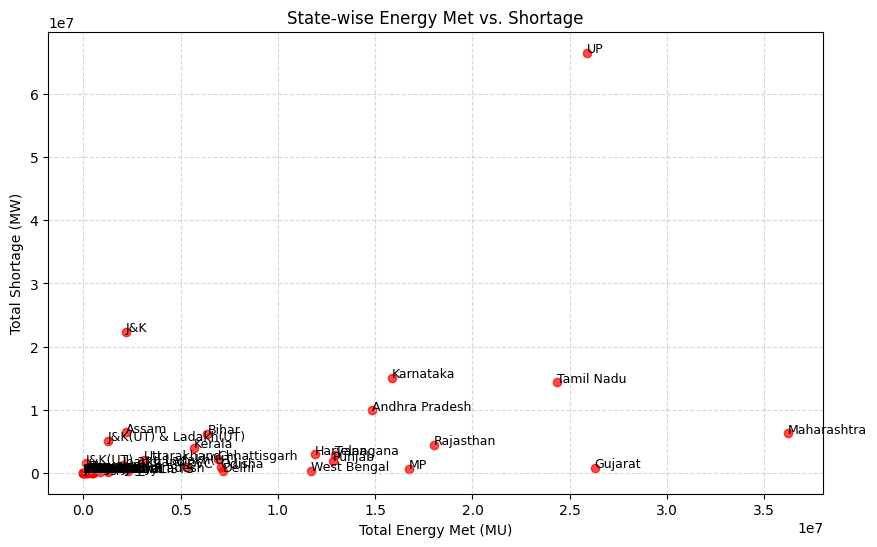

In [119]:
plt.figure(figsize=(10, 6))
state_data = electricity_df.groupby("State_Name")[["Energy_Met_MU", "Shortage_MW"]].sum()

plt.scatter(state_data["Energy_Met_MU"], state_data["Shortage_MW"], color="red", alpha=0.7)
for state in state_data.index:
    plt.annotate(state, (state_data.loc[state, "Energy_Met_MU"], state_data.loc[state, "Shortage_MW"]), fontsize=9)

plt.xlabel("Total Energy Met (MU)")
plt.ylabel("Total Shortage (MW)")
plt.title("State-wise Energy Met vs. Shortage")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [ ]:
# Total Energy Met and Shortage by Region

In [126]:
valid_regions = ["NR", "WR", "NER", "SR", "ER"]
filtered_df = electricity_df[electricity_df["Region_Name"].isin(valid_regions)]


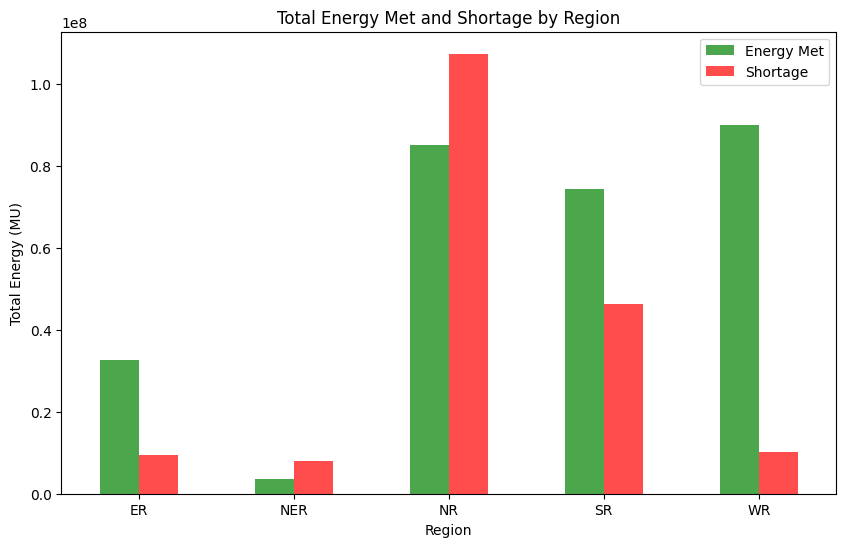

In [127]:
region_totals = filtered_df.groupby("Region_Name")[["Energy_Met_MU", "Shortage_MW"]].sum()

region_totals.plot(kind="bar", figsize=(10, 6), color=["green", "red"], alpha=0.7)
plt.title("Total Energy Met and Shortage by Region")
plt.xlabel("Region")
plt.ylabel("Total Energy (MU)")
plt.xticks(rotation=0)
plt.legend(["Energy Met", "Shortage"])
plt.show()


In [138]:
print(electricity_df.index.name)  # See if date is the index


date


In [139]:
electricity_df.reset_index(inplace=True)


In [ ]:
# Box Plot

C:\Users\rakshita\AppData\Local\Temp\ipykernel_17864\2894475835.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Region_Name", y="Shortage_MW", data=filtered_df, palette="Set2")


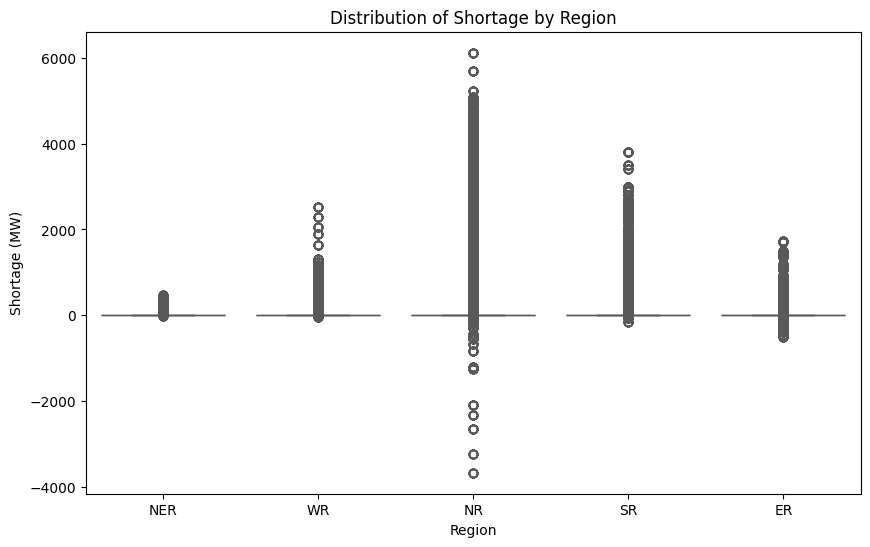

In [129]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Region_Name", y="Shortage_MW", data=filtered_df, palette="Set2")

plt.title("Distribution of Shortage by Region")
plt.xlabel("Region")
plt.ylabel("Shortage (MW)")
plt.show()
